In [1]:
import libsbml
import networkx as nx
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import roadrunner
import pickle
import numpy as np
import os 
from collections import defaultdict
from copy import deepcopy

In [2]:
results_path = '../../../results/real_dataset/large_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 3592,
 'uncertain_species': 206,
 'correct_species': 2665,
 'true_positives': 1298,
 'false_positives': 500,
 'false_negatives': 427,
 'true_negatives': 1367}

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        
        num_parameters = model.getReaction(i).getKineticLaw().getNumParameters()
        is_reversible = False
        if num_parameters == 2:
            is_reversible = True
            
        if is_reversible:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if is_reversible:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if is_reversible:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [4]:
convert_sbml_to_network('BIOMD0000000050.xml')

number reactions 16
number species 14


In [7]:
len(description['reactions'])

16

In [5]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [6]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000050.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [7]:
generate_test_set('BIOMD0000000050.xml', description)

In [3]:
description_path = 'altered_pathways2/reaction7/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['DFG',
  'E1',
  'E2',
  'Cn',
  'Gly',
  '_3DG',
  'FA',
  '_1DG',
  'AA',
  'Man',
  'Glu',
  'MG',
  'Mel',
  'Fru'],
 'reactions': [['v1', 0, 1],
  ['v2', 0, 1],
  ['v3', 0, 1],
  ['v4', 0, 1],
  ['v5', 0, 1],
  ['v6', 0, 1],
  ['v7', 0, 1],
  ['v8', 0, 1],
  ['v9', 0, 1],
  ['v10', 0, 1],
  ['v11', 0, 1],
  ['v12', 0, 1],
  ['v13', 0, 1],
  ['v14', 0, 1],
  ['v15', 0, 1],
  ['v16', 0, 1]],
 'connections': [['DFG', 'v1'],
  ['v1', 'E1'],
  ['DFG', 'v2'],
  ['v2', 'E2'],
  ['DFG', 'v3'],
  ['v3', 'Gly'],
  ['v3', 'Cn'],
  ['E1', 'v4'],
  ['v4', 'Gly'],
  ['v4', '_3DG'],
  ['_3DG', 'v5'],
  ['v5', 'Cn'],
  ['_3DG', 'v6'],
  ['v6', 'FA'],
  ['E2', 'v7'],
  ['v7', 'Gly'],
  ['v7', '_1DG'],
  ['_1DG', 'v8'],
  ['v8', 'Cn'],
  ['_1DG', 'v9'],
  ['v9', 'AA'],
  ['E1', 'v10'],
  ['v10', 'Gly'],
  ['v10', 'Man'],
  ['E1', 'v11'],
  ['v11', 'Gly'],
  ['v11', 'Glu'],
  ['Man', 'v12'],
  ['v12', 'Glu'],
  ['Glu', 'v13'],
  ['v13', '_3DG'],
  ['Gly', 'v14'],
  ['Cn', 'v14'],
  ['v1

In [6]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store' or directory == 'reaction7':
        print('SKIPPING')
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000050.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''

    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 0, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    if total_count != 0:
        print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
        complete_results[directory] = correct_count / total_count


Min and max abs differences:  0.0 1.0308211348842179e-07
ERROR simulation results:  {'DFG': 3.074049628317701e-301}
ERROR simulation results:  {'DFG': 3.074049628317701e-301, 'E1': 2.5689415137105362e-52}
ERROR simulation results:  {'DFG': 3.074049628317701e-301, 'E1': 2.5689415137105362e-52, 'E2': 8.8373269594662e-43}
ERROR simulation results:  {'DFG': 3.074049628317701e-301, 'E1': 2.5689415137105362e-52, 'E2': 8.8373269594662e-43, 'Cn': 0.0002661012328706373}
ERROR simulation results:  {'DFG': 3.074049628317701e-301, 'E1': 2.5689415137105362e-52, 'E2': 8.8373269594662e-43, 'Cn': 0.0002661012328706373, 'Gly': 8.936153059053543}
ERROR simulation results:  {'DFG': 3.074049628317701e-301, 'E1': 2.5689415137105362e-52, 'E2': 8.8373269594662e-43, 'Cn': 0.0002661012328706373, 'Gly': 8.936153059053543, '_3DG': 0.0001313656422220749}
ERROR simulation results:  {'DFG': 3.074049628317701e-301, 'E1': 2.5689415137105362e-52, 'E2': 8.8373269594662e-43, 'Cn': 0.0002661012328706373, 'Gly': 8.9361530

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 439 and h = 3.2985e-09, the corrector convergence test failed repeatedly or with |h| = hmin.


reaction1  total species:  14 correct species:  9 ratio:  0.6428571428571429
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 1.0308211357580848e-07
reaction4  total species:  7 correct species:  7 ratio:  1.0
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 3.724850421284805e-07
reaction9  total species:  10 correct species:  7 ratio:  0.7
Min and max abs differences:  0.0 1.0308211348842179e-07
ERROR simulation results:  {'DFG': 2.1282420090647453e-301}
ERROR simulation results:  {'DFG': 2.1282420090647453e-301, 'E1': 1.1751956040076854e-52}
ERROR simulation results:  {'DFG': 2.1282420090647453e-301, 'E1': 1.1751956040076854e-52, 'E2': 4.520472992527706e-45}
ERROR simulation results:  {'DFG': 2.1282420090647453e-301, 'E1': 1.1751956040076854e-52, 'E2': 4.520472992527706e-45, 'Cn': 0.00044108401847223357}
ERROR simulation results:  {'DFG': 2.1282420090647453e-301, 'E1': 1.1751956040076854e-52, 'E2': 4.

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 442 and h = 3.31925e-09, the corrector convergence test failed repeatedly or with |h| = hmin.


reaction2  total species:  14 correct species:  6 ratio:  0.42857142857142855
Min and max abs differences:  0.0 1.0308211348842179e-07
Converged at time 7710.0
reaction11  total species:  9 correct species:  4 ratio:  0.4444444444444444
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 1.239579141554259e-07
reaction13  total species:  6 correct species:  6 ratio:  1.0
SKIPPING
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 2.3604187375623663e-09
reaction10  total species:  10 correct species:  7 ratio:  0.7
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 1.608002131447961e-07
reaction14  total species:  6 correct species:  6 ratio:  1.0
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 1.0308211356458699e-07
reaction6  total species:  9 correct species:  5 ratio:  0.5555555555555556
Min and max abs differences:  0.0 1.0

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1155 and h = 8.52141e-09, the corrector convergence test failed repeatedly or with |h| = hmin.


reaction0  total species:  14 correct species:  10 ratio:  0.7142857142857143
Min and max abs differences:  0.0 1.0308211348842179e-07
Min and max abs differences:  0.0 1.0308211167739758e-07
reaction12  total species:  8 correct species:  4 ratio:  0.5


In [7]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  140  correct:  95  uncertain:  3  true pos:  45  true neg:  50  false_pos:  24 false neg:  21


In [6]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

KeyError: 'deltas_normal'

In [8]:
results_path = '../../../results/real_dataset/large_class/results2'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [5]:
scores = []
for experiment in complete_results.keys():
    if complete_results[experiment] == 0:
        continue
    scores.append(complete_results[experiment])
print('Average score: ', np.average(scores))

Average score:  0.6720238095238096


In [4]:
scores

[0.75,
 0.7777777777777778,
 0.7,
 0.0,
 0.7857142857142857,
 1.0,
 1.0,
 0.7857142857142857,
 0.5555555555555556,
 0.7142857142857143,
 0.7,
 1.0]

In [16]:
scores

[0.5,
 0.6428571428571429,
 0.7142857142857143,
 0.0,
 0.7857142857142857,
 0.5,
 0.35714285714285715,
 0.7857142857142857]

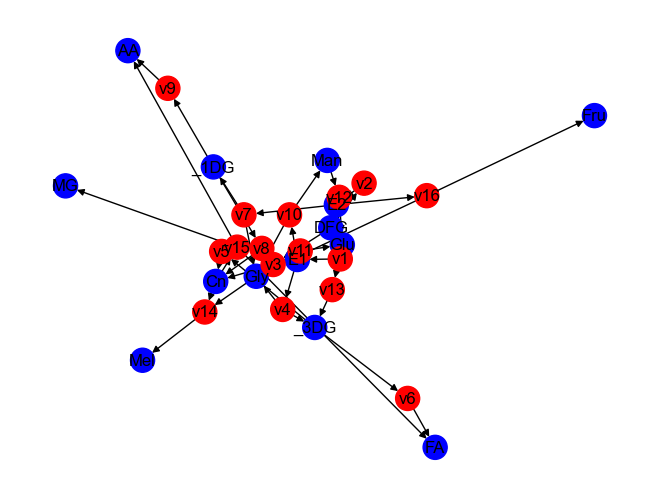

In [6]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [7]:
description_path = 'description_normal'
description_file = open(description_path, 'ab')
pickle.dump(description, description_file)
description_file.close()

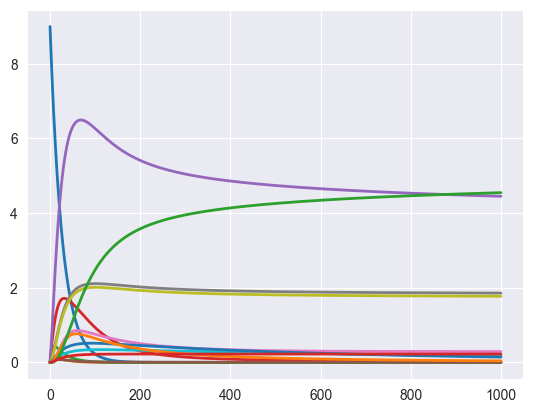

       time,        [DFG],         [E1],         [E2],      [Cn],    [Gly],     [_3DG],       [FA],     [_1DG],       [AA],      [Man],      [Glu],       [MG],       [Mel],       [Fru]
 [[       0,            9,            0,            0,         0,        0,          0,          0,          0,          0,          0,          0,          0,           0,           0],
  [   1.001,       8.6745,    0.0442865,     0.123409,  0.136039,  0.15778, 0.00177883, 0.00110887, 0.00987371, 0.00492795, 0.00164632, 0.00263283, 0.00109204, 2.38458e-05, 0.000864513],
  [   2.002,      8.36077,    0.0767139,      0.21738,  0.265148, 0.344932, 0.00621622, 0.00441539,  0.0326882,  0.0220232, 0.00598593, 0.00956977, 0.00429362, 0.000201379,  0.00317929],
  [   3.003,      8.05839,     0.100087,      0.28803,   0.38763, 0.552784,  0.0122462, 0.00986929,  0.0648105,  0.0492244,  0.0122813,  0.0196277,   0.009497, 0.000706462,  0.00659203],
  [   4.004,      7.76695,     0.116558,     0.340236,  0.503689, 0

In [2]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000050_revert.xml')

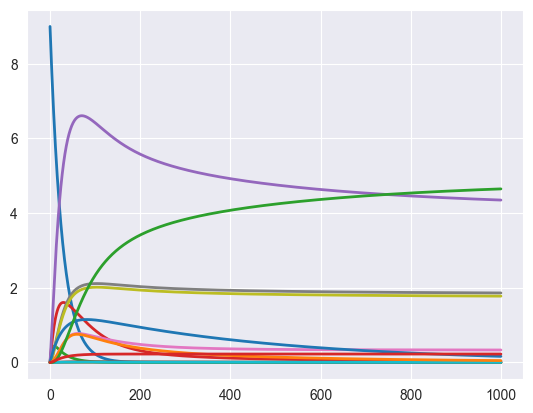

       time,        [DFG],         [E1],         [E2],      [Cn],    [Gly],      [_3DG],       [FA],     [_1DG],       [AA],       [Man],     [Glu],       [MG],       [Mel],       [Fru]
 [[       0,            9,            0,            0,         0,        0,           0,          0,          0,          0,           0,         0,          0,           0,           0],
  [   1.001,       8.6745,   0.00432834,     0.123409,  0.135991, 0.197732, 0.000347167, 0.00109615, 0.00987367, 0.00492781, 0.000284226, 0.0454388, 0.00109186, 2.99725e-05, 0.000864513],
  [   2.002,      8.36077,   0.00417186,      0.21738,  0.264766, 0.417428,  0.00077239, 0.00431012,  0.0326871,  0.0220212, 0.000584628, 0.0933975, 0.00429057,  0.00024757,  0.00317929],
  [   3.003,      8.05839,   0.00402098,      0.28803,  0.386428,  0.64871,  0.00123633,  0.0095291,  0.0648048,  0.0492151, 0.000873918,  0.139513, 0.00948208, 0.000846496,  0.00659203],
  [   4.004,      7.76695,   0.00387555,     0.340236,  0.5010

In [3]:
final_concentrations_altered = functions.plot_simulation_complete('altered_pathways_revert/reaction11/reaction_11_100x.xml')

In [26]:
species = description['species']
species

['DFG',
 'E1',
 'E2',
 'Cn',
 'Gly',
 '_3DG',
 'FA',
 '_1DG',
 'AA',
 'Man',
 'Glu',
 'MG',
 'Mel',
 'Fru']

In [37]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [38]:
final_normal

[ 1.00000000e+04 -1.82801551e-25 -4.60233661e-27 -1.50804029e-26
  1.04371699e-05  4.13882347e+00  1.38040192e-06  3.23391856e-01
  1.83647021e+00  1.75245169e+00  1.28800706e-04  7.36005191e-05
  1.66487313e-05  4.86117653e+00  2.26312143e-01]

In [39]:
temp = final_concentrations_normal[1]
temp

[9. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [40]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'paired delta', paired_delta)

DFG
final normal:  -1.828015507200014e-25 final altered:  1.367390562209625e-27 delta:  1.8416894128221104e-25 relative delta  -1.007480191261091 initial concentration:  9.0 delta1 2.046321569802345e-26 paired delta 2.061628446526162e-26
E1
final normal:  -4.6023366087596394e-27 final altered:  6.8230075412488155e-31 delta:  4.603018909513765e-27 relative delta  -1.00014825094558 initial concentration:  0.0 delta1 0 paired delta 0.010001482509455796
E2
final normal:  -1.5080402915028914e-26 final altered:  1.1280429809873183e-28 delta:  1.5193207213127646e-26 relative delta  -1.0074801912610911 initial concentration:  0.0 delta1 0 paired delta 0.010074801912610912
Cn
final normal:  1.0437169893917196e-05 final altered:  2.3909274501033424e-07 delta:  -1.0198077148906861e-05 relative delta  -0.9770921861538655 initial concentration:  0.0 delta1 0 paired delta 0.009770921861538655
Gly
final normal:  4.138823466589125 final altered:  4.138644092970152 delta:  -0.00017937361897324422 relat

In [16]:
(1 - (2.6e-17 / 6.6e-14)) / 100

0.009996060606060606

In [16]:
description['reactions']

[['v1', 0, 1],
 ['v2', 0, 1],
 ['v3', 0, 1],
 ['v4', 0, 1],
 ['v5', 0, 1],
 ['v6', 0, 1],
 ['v7', 0, 1],
 ['v8', 0, 1],
 ['v9', 0, 1],
 ['v10', 0, 1],
 ['v11', 0, 1],
 ['v12', 0, 1],
 ['v13', 0, 1],
 ['v14', 0, 1],
 ['v15', 0, 1],
 ['v16', 0, 1]]

In [17]:
description['altered'] = 'v1'

In [18]:
description_path = 'description_v1_altered'
description_file = open(description_path, 'ab')
pickle.dump(description, description_file)
description_file.close()

In [13]:
description['reactions'][0][1] = 0.2
description

{'species': ['DFG',
  'E1',
  'E2',
  'Cn',
  'Gly',
  '_3DG',
  'FA',
  '_1DG',
  'AA',
  'Man',
  'Glu',
  'MG',
  'Mel',
  'Fru'],
 'reactions': [['v1', 0.2, 1],
  ['v2', 0, 1],
  ['v3', 0, 1],
  ['v4', 0, 1],
  ['v5', 0, 1],
  ['v6', 0, 1],
  ['v7', 0, 1],
  ['v8', 0, 1],
  ['v9', 0, 1],
  ['v10', 0, 1],
  ['v11', 0, 1],
  ['v12', 0, 1],
  ['v13', 0, 1],
  ['v14', 0, 1],
  ['v15', 0, 1],
  ['v16', 0, 1]],
 'connections': [['DFG', 'v1'],
  ['v1', 'E1'],
  ['DFG', 'v2'],
  ['v2', 'E2'],
  ['DFG', 'v3'],
  ['v3', 'Gly'],
  ['v3', 'Cn'],
  ['E1', 'v4'],
  ['v4', 'Gly'],
  ['v4', '_3DG'],
  ['_3DG', 'v5'],
  ['v5', 'Cn'],
  ['_3DG', 'v6'],
  ['v6', 'FA'],
  ['E2', 'v7'],
  ['v7', 'Gly'],
  ['v7', '_1DG'],
  ['_1DG', 'v8'],
  ['v8', 'Cn'],
  ['_1DG', 'v9'],
  ['v9', 'AA'],
  ['E1', 'v10'],
  ['v10', 'Gly'],
  ['v10', 'Man'],
  ['E1', 'v11'],
  ['v11', 'Gly'],
  ['v11', 'Glu'],
  ['Man', 'v12'],
  ['v12', 'Glu'],
  ['Glu', 'v13'],
  ['v13', '_3DG'],
  ['Gly', 'v14'],
  ['Cn', 'v14'],
  ['

In [14]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [15]:
graph = graph_functions.generate_graph(description)

In [16]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'DFG': 0.5, 'E1': 0.5, 'E2': 0.5, 'Cn': 0.5, 'Gly': 0.5, '_3DG': 0.5, 'FA': 0.5, '_1DG': 0.5, 'AA': 0.5, 'Man': 0.5, 'Glu': 0.5, 'MG': 0.5, 'Mel': 0.5, 'Fru': 0.5}
Firing reaction  v1
reactant:  DFG  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.43411143347478365}
new reaction strength:  0.0  reaction weight:  0.43411143347478365  reaction strength  0.2
reactant:  DFG  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  E1 new value:  0.6899744811276125
Firing reaction  v2
reactant:  DFG  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.3682442521590358}
new reaction strength:  0.0  reaction weight:  0.3682442521590358  reaction strength  0
reactant:  DFG  new value:  0.5  delta:  0.0
product:  E2 new value:  0.5
Firing reaction  v3
reactant:  DFG  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.4936494743229993}
new reaction strength:  0.0  reaction weight:  0.4936494743229993  react

In [17]:
species_propagation

[{'DFG': 0.31002551887238755,
  'E1': 0.6899744811276125,
  'E2': 0.5,
  'Cn': 0.5,
  'Gly': 0.5,
  '_3DG': 0.5,
  'FA': 0.5,
  '_1DG': 0.5,
  'AA': 0.5,
  'Man': 0.5,
  'Glu': 0.5,
  'MG': 0.5,
  'Mel': 0.5,
  'Fru': 0.5},
 {'DFG': 0.47793421986988777,
  'E1': 0.490671636222595,
  'E2': 0.28092603044117087,
  'Cn': 0.26829713163016333,
  'Gly': 0.6227671526039757,
  '_3DG': 0.7420502292422141,
  'FA': 0.5,
  '_1DG': 0.5,
  'AA': 0.5,
  'Man': 0.7116595448727965,
  'Glu': 0.7690617046707292,
  'MG': 0.5,
  'Mel': 0.5,
  'Fru': 0.5},
 {'DFG': 0.4418986888450388,
  'E1': 0.5417960947189766,
  'E2': 0.44476841340187306,
  'Cn': 0.3980783629776363,
  'Gly': 0.5456094712889251,
  '_3DG': 0.6390423864880517,
  'FA': 0.49137208331129717,
  '_1DG': 0.24247757726135422,
  'AA': 0.2193547050314797,
  'Man': 0.5604894349098969,
  'Glu': 0.6968032854850951,
  'MG': 0.2193547050314797,
  'Mel': 0.4413201716599264,
  'Fru': 0.2612929521117248},
 {'DFG': 0.44828578370088995,
  'E1': 0.531974955499199

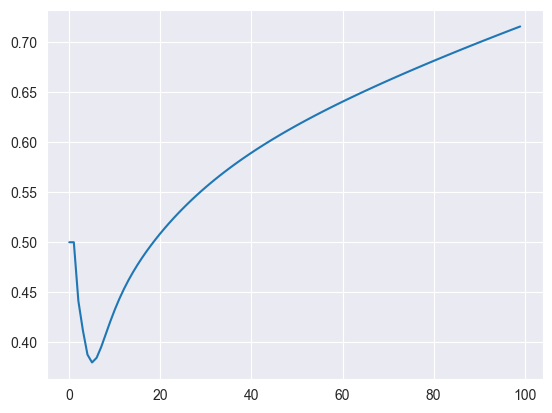

In [18]:
import matplotlib.pyplot as plt
concentrations = [conc['Mel'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [19]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

DFG propagation results:  0.4388156381909204 simulation results:  unchanged
E1 propagation results:  0.5407762000760319 simulation results:  decreased
E2 propagation results:  0.47022210269149933 simulation results:  decreased
Cn propagation results:  0.48260671500694846 simulation results:  increased
Gly propagation results:  0.5215798041561455 simulation results:  decreased
_3DG propagation results:  0.5575510788582497 simulation results:  increased
FA propagation results:  0.9987626863471295 simulation results:  increased
_1DG propagation results:  0.4852260910251731 simulation results:  decreased
AA propagation results:  6.582346484873547e-05 simulation results:  decreased
Man propagation results:  0.538090898091212 simulation results:  increased
Glu propagation results:  0.576236027630038 simulation results:  increased
MG propagation results:  4.162390498430035e-05 simulation results:  unchanged
Mel propagation results:  0.7154066529546452 simulation results:  increased
Fru propag

In [19]:
res = complete_tests.complete_tests2(
            'BIOMD0000000050_revert.xml',
            'altered_pathways_revert/reaction0/reaction_0_100x.xml',
            'altered_pathways_revert/reaction0/description',
            []
        )

In [20]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)

out of interval, restricting confidence:  5.0 95.0 0.49843503887428126 0.5260254194068504
out of interval, restricting confidence:  7.5 92.5 0.49964233942817576 0.5243759380143171
out of interval, restricting confidence:  10.0 90.0 0.50082813868287 0.5234295267170098
Specie:  DFG expected result:  increased  normal final:  -7.0351765368423825e-28  altered final:  7.105806929884255e-73
confidence interval:  [0.007444018278603961, 0.01000591851842369]
deltas coming from simulation:  [7.0351765368423825e-28, 7.816862818713758e-29]
Specie:  E1 expected result:  increased  normal final:  -1.771271031427563e-29  altered final:  9.630580493642708e-26
confidence interval:  [0.9332822408835334, 0.9430007725984986]
deltas coming from simulation:  [9.632351764674136e-26, 54.381015630967006]
Specie:  E2 expected result:  increased  normal final:  -5.803171547178105e-29  altered final:  1.7747805722726155e-25
confidence interval:  [0.2866597401399948, 0.29933096106069207]
deltas coming from simulat

In [22]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  DFG
 lower:  0.4353271477972497  higher:  0.43573062651960526
decrease, expected:  unchanged
specie:  E1
 lower:  0.5435084078310615  higher:  0.5438381303553821
increase, expected:  decreased
specie:  E2
 lower:  0.46773719213850734  higher:  0.46812208975458064
decrease, expected:  decreased
specie:  Cn
 lower:  0.4755732897448954  higher:  0.47646126581300013
decrease, expected:  increased
specie:  Gly
 lower:  0.5359006006905913  higher:  0.5370076980258522
increase, expected:  decreased
specie:  _3DG
 lower:  0.5629014134470045  higher:  0.5634851747210841
increase, expected:  increased
specie:  FA
 lower:  0.7294473533455402  higher:  0.7377096338940657
increase, expected:  increased
specie:  _1DG
 lower:  0.48395651663242323  higher:  0.48418748096141595
decrease, expected:  decreased
specie:  AA
 lower:  0.07684846087623957  higher:  0.08158503126078666
decrease, expected:  decreased
specie:  Man
 lower:  0.5440912773309241  higher:  0.5447970552133583
increase, expect

<Axes: ylabel='Count'>

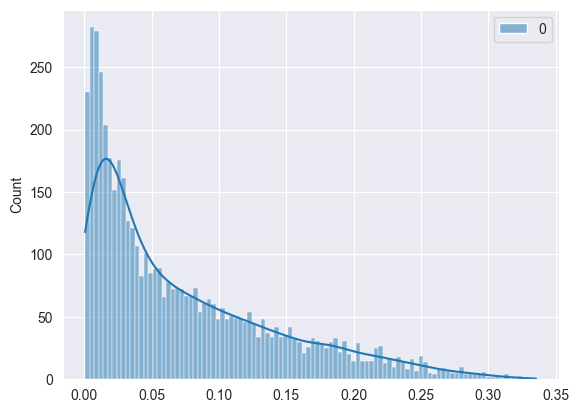

In [25]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['Fru'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)